# Convert a legacy Visium sample
We provide an example of how we leveraged the hest-lib to assemble HEST-1k from legacy files.

In [ ]:
%%bash
# As an example, download the files from the following NCBI study:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6215674)

mkdir downloads
cd downloads
wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6215nnn/GSM6215674/suppl/GSM6215674%5FS13.png.gz
gunzip GSM6215674_S13.png.gz
wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6215nnn/GSM6215674/suppl/GSM6215674%5FS13%5Ffiltered%5Ffeature%5Fbc%5Fmatrix.h5

Then simply read the files with the hest API. No alignment file is provided in this study, so hest will automatically align the spots with fiducials detection.

In [ ]:
from hest import VisiumReader

fullres_img_path = 'downloads/GSM6215674_S13.png'
bc_matrix_path = 'downloads/GSM6215674_S13_filtered_feature_bc_matrix.h5'

st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    save_autoalign=True
)

In [2]:
st.save(path='processed')

saving to pyramidal tiff... can be slow


You can also visualize an overlay of the aligned spots on the downscaled WSI

Plotting spatial plots...


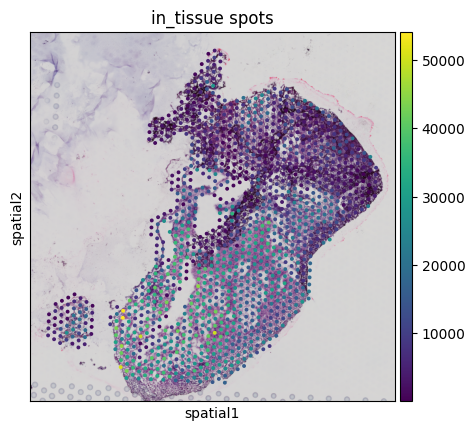

H&E overlay spatial plots saved in processed


In [3]:
st.save_spatial_plot(save_path='processed')

## Hest reader API

## Reading legacy Visium files

### When should I provide an alignment file and when should I use the autoalignment?

#### Step 1: check if a tissue_positions.csv/tissue_position_list.csv already provides a correct alignment
Most of the time if a spatial/ folder containing a tissue_positions.csv/tissue_position_list.csv is available you don't need any autoalignment/alignment file. Try the following: `st = VisiumReader().read(fullres_img_path, bc_matric_path, spatial_coord_path=spatial_path)` (where `spatial_path` is a folder that contains a tissue_positions.csv or a tissue_position_list.csv), you can then double check the alignment (`st.save_spatial_plot(save_dir)`) by saving a visualization plot that takes the full resolution image, downscale it and overlays it with the spots. If the alignment looks off, try step 2.

#### Step 2: check if a .json alignment file is provided
If a .json alignment file is available, try the following `VisiumReader().read(fullres_img_path, bc_matric_path, spatial_coord_path=spatial_path, alignment_file_path=align_path)` you can also ommit the spatial_coord_path `VisiumReader().read(fullres_img_path, bc_matric_path, alignment_file_path=align_path)`

#### Step 3: attempt auto-alignment
If at least 3 corner fiducials are not cropped out and are reasonably visible, you can attempt an autoalignment with `VisiumReader().read(fullres_img_path, bc_matric_path`. (if no spatial folder and no alignment_file_path is provided, it will attempt autoalignment by default, you can always force auto-alignment by passing `autoalign='always'`)

### Reading from a filtered_feature_bc_matrix.h5, an image and a spatial/ folder

In [ ]:
from hest import VisiumReader

fullres_img_path = 'my_path/image.tif'
bc_matrix_path = 'my_path/filtered_bc_matrix.h5'
spatial_coord_path = 'my_path/spatial'
alignment_file_path = 'my_path/alignment.txt'

st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    spatial_coord_path=spatial_coord_path # path to a space ranger spatial/ folder containing either a tissue_positions.csv or tissue_position_list.csv
)

# if no spatial folder is provided, but you have an alignment file
st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
    alignment_file_path=alignment_file_path # path to a .json alignment file
)

# if both the alignment file and the spatial folder are missing, attempt autoalignment
st = VisiumReader().read(
    fullres_img_path, # path to a full res image
    bc_matrix_path, # path to filtered_feature_bc_matrix.h5
)


### Auto read
Given that `visium_dir` contains a full resolution image and all the necessary Visium files such as the `filtered_bc_matrix.h5` and the `spatial` folder, `VisiumReader.auto_read(path)` should be able to automatically read the sample. Prefer `read` for a more fine grain control.


In [ ]:
from hest import VisiumReader

visium_dir = ...

# attempt autoread
st = VisiumReader().auto_read(visium_dir)